## Попробуем простую нейросеть PyTorch (2 скрытых слоя + Dropout + BatchNorm), подбор гиперпараметров Optuna
- **помним про временные split, признаки и метрики те же**

## 1. импорты

In [1]:
# импорты
import os, warnings, time, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             confusion_matrix)
from sklearn.preprocessing import RobustScaler


warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

RANDOM_STATE = 42

def set_seed(seed=RANDOM_STATE):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## 2.Загрузки

In [2]:
# поиск пути от текущего файла в папку
# anomaly_detection_project\data\raw где лежит датасет
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()   # путь к текущему файлу

    while True:
        # Проверяем, находится ли проект в текущем каталоге
        # если найден лепим и возвращаем нужный путь к данным
        if project_name in os.listdir(current_path):
            # Строим путь до нужной папки внутри проекта
            return os.path.join(current_path, project_name, path_to_data)

        parent_path = os.path.dirname(current_path)

        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден в родительских каталогах.")
        # если проекта нет поднимаемся выше
        current_path = parent_path

# Получаем путь
full_path_to_cc_1_02_00 = find_path_within_project(
    "anomaly_detection_project",
    os.path.join("data", "raw",'creditcard_1_02_00.csv' )
)

# файл creditcard_1_02_00.csv лежит в папке data/raw/
# там добавлены новые колонки времени и суммы
# print(f"Загрузка данных из {full_path}")
df = pd.read_csv(full_path_to_cc_1_02_00)

# посмотрим ка
print("\n")
print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")
print(f"\nДанные. Первые строки:")
display(df.head(2))
print("Список колонок без PCA: \n", *df.columns[~df.columns.str.startswith('V')])



Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Данные. Первые строки:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,Time_hour,Time_day,Time_abs_hour,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0,1.305626


Список колонок без PCA: 
 Time Amount Class Time_hour Time_day Time_abs_hour Amount_log


## 3. splits

In [5]:
# колонка для сплита
time_column = 'Time_abs_hour'

# Выделим для теста последние 8 часов
def get_train_test(df, col, train_finish,
                   train_start = 0, test_finish = 0, gap = 0,
                   easy_check =True):
    '''делим df на train и test
        - gap -зазор между train и test (возможно и не пригодиццо)
    '''
    # определяем test_start и test_finish
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test =  df[(df[col] >= test_start) & (df[col] <= test_finish)]
    if  easy_check:
        print("easy checking: \n",
              f"train min {df_train[col].min()}, train max {df_train[col].max()}\n" ,
              f"test min {df_test[col].min()}, test max {df_test[col].max()}")
    return df_train, df_test

# делим на трейн тест
time_col = 'Time_abs_hour'
train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col , train_finish)
print("\nОтрезали тестовую выборку.")
print(f"Размеры train:{df_train.shape} test: {df_test.shape} .\n")

# делаем ещё один тайм сплит для подбора гиперпараметров
# можно конечно в оптуну загрузить и time кросс-валидацию но и так должно сработать...
train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col , train_finish_2)
print("\nПорезали тренировочную выборку.")
print(f"Размеры train_2 :{df_train_2.shape} val: {df_val.shape} .")

easy checking: 
 train min 0.0, train max 39.0
 test min 40.0, test max 47.0

Отрезали тестовую выборку.
Размеры train:(224865, 35) test: (59942, 35) .

easy checking: 
 train min 0.0, train max 31.0
 test min 32.0, test max 39.0

Порезали тренировочную выборку.
Размеры train_2 :(162525, 35) val: (62340, 35) .


In [6]:
# признаки
unnecessary_cols = ['Time','Amount','Time_hour','Time_day','Amount_log', time_col]
target_col = 'Class'
drop_cols = [target_col] + unnecessary_cols

def xy(df):
    return df.drop(drop_cols, axis=1).values.astype('float32'), df[target_col].values

X_tr, y_tr = xy(df_train_2)
X_val, y_val = xy(df_val)
X_test, y_test = xy(df_test)
# полный трейн
X_train, y_train  = xy(df_train)

# размерности
n_features = X_tr.shape[1]
print("n_features:", n_features)

n_features: 28


## 4. PyTorch Dataset / Loader

In [7]:
BATCH_SIZE = 1024
# датасеты
train_ds  = TensorDataset(torch.from_numpy(X_train),  torch.from_numpy(y_train))
tr_ds  = TensorDataset(torch.from_numpy(X_tr),  torch.from_numpy(y_tr))
val_ds    = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds   = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))

# даталодеры
train_dl  = DataLoader(train_ds,  batch_size=BATCH_SIZE, shuffle=True)
tr_dl  = DataLoader(tr_ds,  batch_size=BATCH_SIZE, shuffle=True)
val_dl    = DataLoader(val_ds,    batch_size=BATCH_SIZE)
test_dl   = DataLoader(test_ds,   batch_size=BATCH_SIZE)

## 5. Модель

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1),
        )

    def forward(self, x):
        return self.net(x)

# для инициализации весов
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

## 6. валидация, обучение

In [9]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()  # настраиваем на обучение
    total_loss, n = 0., 0  # задаём стартовые значения
    for X, y in loader:
        X, y = X.to(device), y.float().to(device)
        optimizer.zero_grad()    # обнуляем градиенты
        preds = model(X).squeeze(1)  # prediction
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        # собираем результат в кучку
        total_loss += loss.item() * len(X)
        n += len(X)
    # возвращаем среднее за эпоху
    return total_loss / n

@torch.no_grad()
def valid_epoch(model, loader, criterion):
    model.eval()  # режим оценки
    # стартовая инициализация
    total_loss, n = 0., 0
    all_preds, all_labels = [], []
    for X, y in loader:
        X, y = X.to(device), y.float().to(device)
        preds = torch.sigmoid(model(X).squeeze(1))
        total_loss += criterion(preds, y).item() * len(X)
        n += len(X)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

    preds = torch.cat(all_preds).numpy()
    labels = torch.cat(all_labels).numpy()
    pr_auc = auc(*precision_recall_curve(labels, preds)[1::-1])
    roc_auc = roc_auc_score(labels, preds)
    return total_loss / n, pr_auc, roc_auc

## 7. optuna objective

In [22]:
N_Epochs = 100
def objective(trial):
    lr        = trial.suggest_float("lr", 1e-4, 3e-2, log=True)
    hidden1   = trial.suggest_categorical("hidden1", [2**i for i in range(6, 9)])
    hidden2   = trial.suggest_categorical("hidden2", [2**i for i in range(4, 9)])
    dropout   = trial.suggest_float("dropout", 0.1, 0.5)
    wd        = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

    gamma     = trial.suggest_float("gamma", 0.70, 0.99)  # для scheduler

    # инициализируем модел
    model = SimpleNN(n_features, hidden1, hidden2, dropout).to(device)
    model.apply(weights_init)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    # бинарная кросс-энтропия с логитами, pos_weight — балансировка классов  классы же несбалансированы
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(y_tr)/y_tr.sum()]).to(device))

    # Если PR AUC не улучшается 5 эпох подряд — обучение прерывается
    best_pr = 0
    waiting = 5
    no_improvement = 0

    for epoch in range(N_Epochs):
        train_loss = train_epoch(model, tr_dl, optimizer, criterion)
        val_loss, val_pr, val_roc = valid_epoch(model, val_dl, criterion)

        scheduler.step()  # обновляем lr

        if val_pr > best_pr:
            best_pr = val_pr
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= waiting:
            break

    print(f"\nУчились {epoch} эпох.")
    return best_pr

In [25]:
set_seed()

study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-08-30 22:22:59,119] A new study created in memory with name: no-name-39cc8b12-45b3-4dcb-858a-354361706570


  0%|          | 0/30 [00:00<?, ?it/s]


Учились 22 эпох.
[I 2025-08-30 22:23:54,068] Trial 0 finished with value: 0.7581313010069914 and parameters: {'lr': 0.0008468008575248334, 'hidden1': 64, 'hidden2': 128, 'dropout': 0.3832290311184182, 'weight_decay': 1.2087541473056965e-06, 'gamma': 0.9812738571269783}. Best is trial 0 with value: 0.7581313010069914.

Учились 6 эпох.
[I 2025-08-30 22:24:12,375] Trial 1 finished with value: 0.7496822529653013 and parameters: {'lr': 0.011536162338241389, 'hidden1': 64, 'hidden2': 256, 'dropout': 0.15579754426081674, 'weight_decay': 1.4742753159914662e-05, 'gamma': 0.8062449345551705}. Best is trial 0 with value: 0.7581313010069914.

Учились 65 эпох.
[I 2025-08-30 22:26:46,017] Trial 2 finished with value: 0.7593012554628468 and parameters: {'lr': 0.0013481575603601424, 'hidden1': 64, 'hidden2': 64, 'dropout': 0.4795542149013333, 'weight_decay': 0.007286653737491046, 'gamma': 0.9344352309537737}. Best is trial 2 with value: 0.7593012554628468.

Учились 35 эпох.
[I 2025-08-30 22:28:14,367

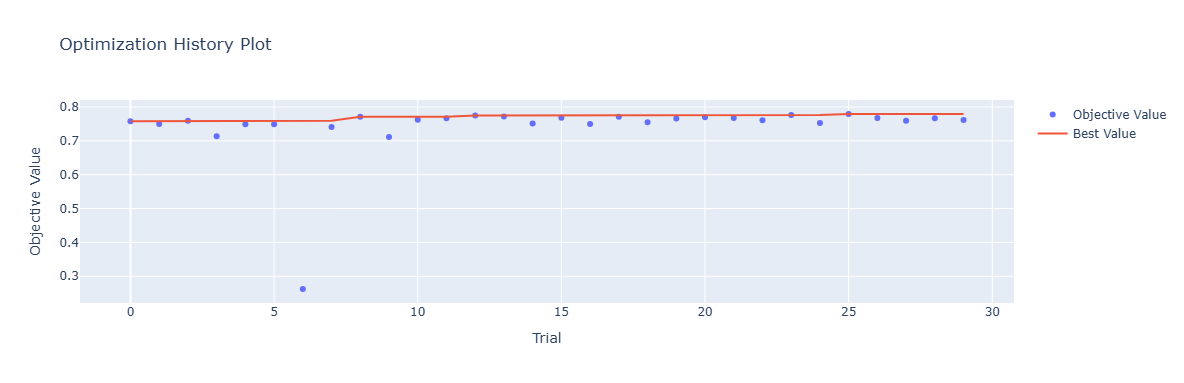

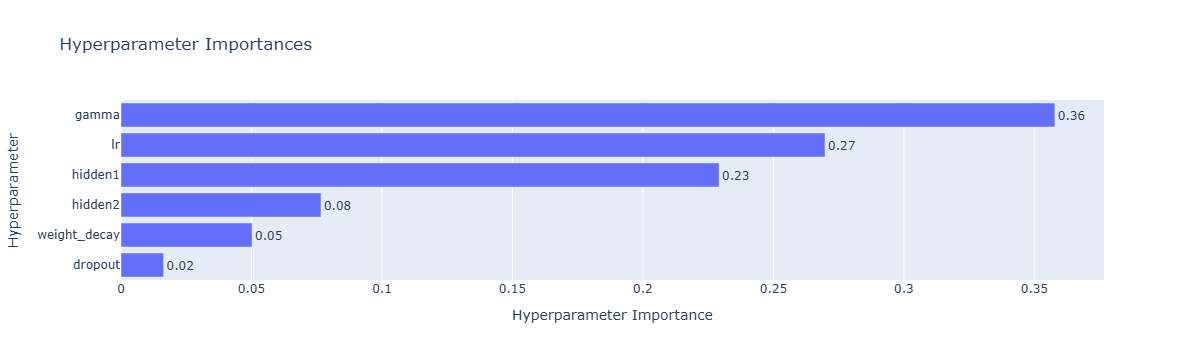

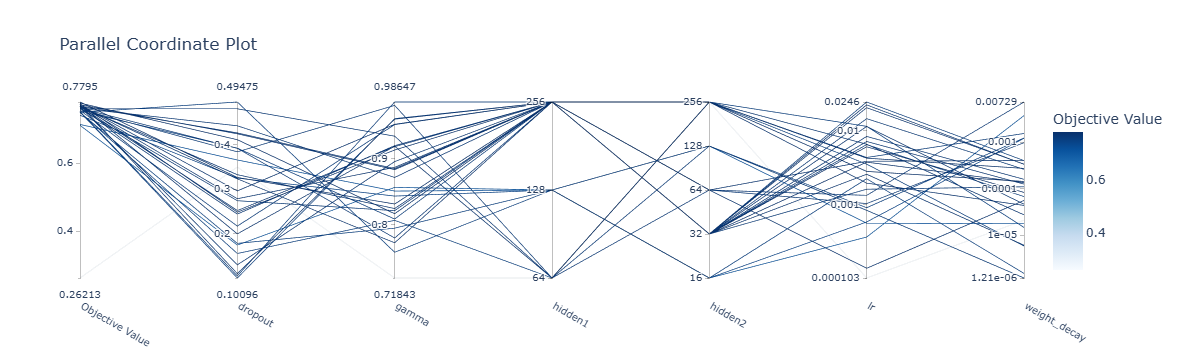

In [26]:
# optuna визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

## 8. Обучение на всём train
(отрисовка метрик на тест - чисто посмотреть , в реальности у нас этого не будет)

In [27]:
def train_with_plot_and_scheduler(model, train_loader, val_loader, optimizer, criterion, epochs, gamma=0.9):

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    train_losses = []
    val_losses = []
    pr_aucs = []
    roc_aucs = []
    lrs = []

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, pr_auc, roc_auc = valid_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pr_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)
        lrs.append(optimizer.param_groups[0]['lr'])

        scheduler.step()  # обновляем learning rate

        # Обновление графика
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # Потери
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss по эпохам')
        plt.legend()
        plt.xlim(0, epochs)

        # Метрики
        plt.subplot(1, 3, 2)
        plt.plot(pr_aucs, label='PR AUC')
        plt.plot(roc_aucs, label='ROC AUC')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Тест Metrics')
        plt.legend()
        plt.xlim(0, epochs)

        # Learning Rate
        plt.subplot(1, 3, 3)
        plt.plot(lrs, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.xlim(0, epochs)

        plt.tight_layout()
        plt.show()

        print(f"Эпоха {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}, LR: {lrs[-1]:.6f}")


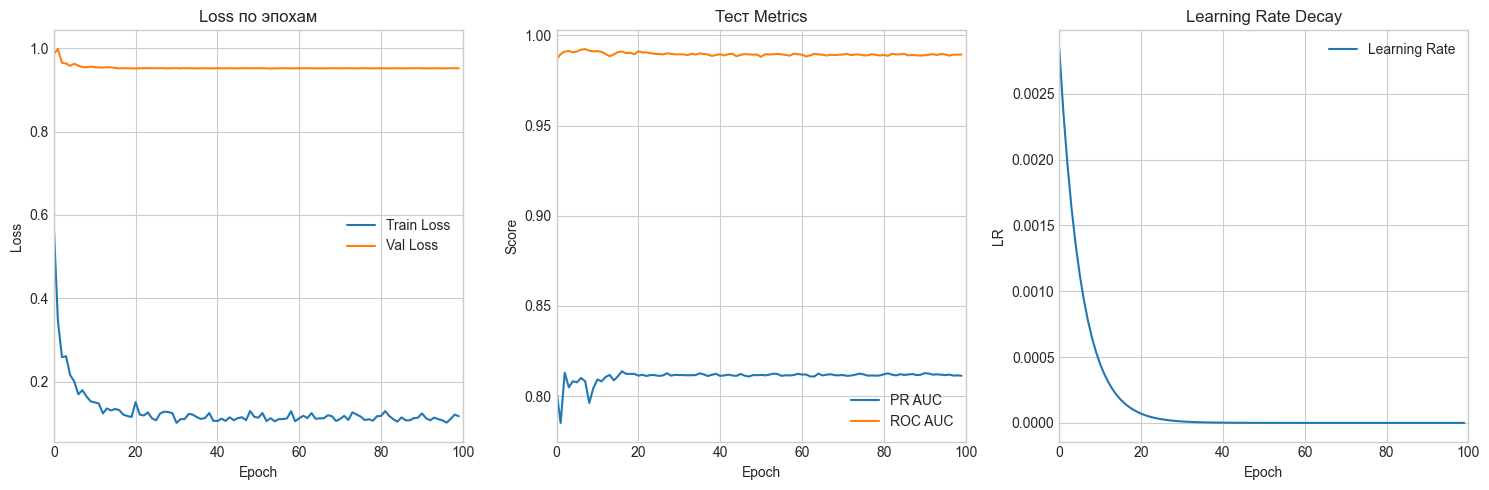

Эпоха 100/100 — Train Loss: 0.1173, Val Loss: 0.9519, PR AUC: 0.8113, ROC AUC: 0.9894, LR: 0.000000


In [28]:
set_seed()

best = study.best_params
model = SimpleNN(n_features, best["hidden1"], best["hidden2"], best["dropout"]).to(device)
model.apply(weights_init)
optimizer = torch.optim.AdamW(model.parameters(), lr=best["lr"], weight_decay=best["weight_decay"])
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(y_train)/y_train.sum()]).to(device))


train_with_plot_and_scheduler(model, train_dl, test_dl, optimizer, criterion, 100, gamma=best['gamma'])

## 9. Оценка на test

In [29]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    preds = []
    for X, _ in loader:
        preds.append(torch.sigmoid(model(X.to(device)).squeeze(1)).cpu())
    return torch.cat(preds).numpy()

y_score = predict(model, test_dl)
y_pred = (y_score >= 0.5).astype(int)

pr_auc  = auc(*precision_recall_curve(y_test, y_score)[1::-1])
roc_auc = roc_auc_score(y_test, y_score)

print(f"Torch Simple   PR-AUC={pr_auc:0.4f}  ROC-AUC={roc_auc:0.4f}  "
      f"Precision={precision_score(y_test,y_pred):0.3f}  Recall={recall_score(y_test,y_pred):0.3f}")

Torch Simple   PR-AUC=0.8113  ROC-AUC=0.9894  Precision=0.088  Recall=0.909


## 10. Сохранение модел

In [ ]:
# torch.save(model.state_dict(), "simple_torch_creditcard.pt")

## 11. подбор порога

In [75]:
# получаем вероятности на валидации
# по хорошему порог нужно подбирать обучив модель только на X_tr...)
# но, кмк, ничего сильно противозаконного не происходит ...)
model.eval()
with torch.no_grad():
    val_tensor = torch.from_numpy(X_val).to(device)
    y_score_val = torch.sigmoid(model(val_tensor).squeeze(1)).cpu().numpy()

#  подбираем порог
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

prec_val, rec_val, thr_val = precision_recall_curve(y_val, y_score_val)
f1_val = 2 * prec_val * rec_val / (prec_val + rec_val + 1e-12)
best_idx = np.nanargmax(f1_val)   # nanargmax игнорирует NaN
best_thr = thr_val[best_idx]

print(f"Оптимальный порог (по val) = {best_thr:.4f}")

Оптимальный порог (по val) = 0.9996


In [76]:
y_pred_test = (y_score >= best_thr).astype(int)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

prec, rec, thr = precision_recall_curve(y_test, y_score)
pr_auc  = auc(rec, prec)

print("Test (порог подобран по валидации)  "
      f"PR-AUC={pr_auc:0.4f}  "
      f"Precision={precision:0.3f}  "
      f"Recall={recall:0.3f}, F1 = {f1:.3f}")

Test (порог подобран по валидации)  PR-AUC=0.8113  Precision=0.902  Recall=0.714, F1 = 0.797


## 12. Оценка-отрисовка finaly

In [32]:
# precision-recall кривая и confusion_matrix и метрики
# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc

def plot_pr_and_cm(recalls, precisions, y_true, y_pred, main_label = ' на test',):
# # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')


    labels = ['Норм (0)', 'Аномалии (1)']

    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

    # cm
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()

    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)
    pass

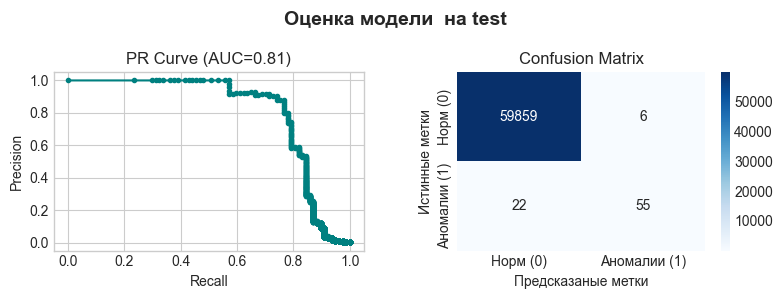


Precision=0.90,   Recall=0.71,   F1=0.80,   PR_AUC=0.81



In [33]:
plot_pr_and_cm(recalls=rec, precisions=prec, y_true=y_test, y_pred= y_pred_test, main_label = ' на test',)

## 13. Выводы
**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **простенькая нейронка**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Test**     | 0.80 | 0.81   |

**Вывод**
- Модель справилась с задачей детекции аномалий.
Простая полносвязная нейросеть с двумя скрытыми слоями, Dropout и BatchNorm показала устойчивую и высокую производительность на тестовой выборке:
- - PR-AUC: 0.81 — хороший результат для несбалансированных данных (аномалий всего 0.17%).
- -  Precision: 0.90, Recall: 0.71, F1: 0.80 — при оптимальном пороге 0.9996, подобранном на валидации
- Подбор гиперпараметров через Optuna был эффективен.
- - Лучшие параметры:
- - hidden1 = 256, hidden2 = 256, dropout = 0.33, lr = 0.0028, gamma = 0.83
- - Оптимизация позволила улучшить PR-AUC с ~0.75 до 0.777 на валидации и добиться устойчивой работы на тесте.
- Модель справилась с дисбалансом классов (0.17% аномалий)
- Подбор порога классификации - важен: Исходно модель с порогом 0.5 давала высокий Recall (0.818) но низкий Precision (0.321). Это типично для несбалансированных данных. Последующий подбор оптимального порога  на валидационной выборке позволил найти баланс и значительно улучшить F1-меру, получив сильные значения и Precision (0.90), и Recall (0.71)
  **Что можно улучшать:**
- Попробовать более сложные архитектуры (ResNet-like, TabNet, ...)
- Добавить интерпретацию признаков.

## Happy end.....